# パーセプトロンの実装

パーセプトロンを実装  
適当なサンプルで学習  
学習ごとの直線の動きをプロット  
色々なデータで試す  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from abc import ABCMeta, abstractmethod
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [2]:
def get_data():
    X, Y = make_classification(
        random_state=None,
        n_features=2, 
        n_redundant=0, 
        n_informative=1,
        n_clusters_per_class=1,
        n_classes=2)
    df = pd.DataFrame(data=X)
    df['target'] = Y
    return df

In [3]:
class Dataset():
    """
    Datasetです
    """
    def __init__(self, train, label):
        self.df_train = train
        self.sr_label = label
    
    @classmethod
    def create(clf, train, label):
        """
        インスタンス生成メソッドです。
        引数の整合性を確認してコンストラクタを呼び出します。
        """
        if type(train) != pd.DataFrame:
            raise Exception('train type must be pd.DataFrame')
        if type(label) != pd.Series: 
            raise Exception('label type must be pd.Series')
        if train.shape[0] != label.size:
            raise Exception('train と label のデータが一致しません')
        return clf(train=train, label=label)
        
    
    def print_shape(self):
        print(f"train : {self.df_train.shape}")
        print(f"label : {self.sr_label.shape}")
    
    @property
    def range(self):
        """
        テストデータのレンジ
        """
        return self.df_train.max(), self.df_train.min()
    
    @property
    def count(self):
        """
        データ数
        """
        return self.sr_label.count()
    
    def get_rows(self): # TODO ランダムの実装
        """
        データセットを一行取り出します
        """
        for (index, train), label in zip(self.df_train.iterrows(), self.sr_label):
            yield train, label
    
            
""" test """
df = get_data()
train = df.drop('target', axis=1)
label = df['target']
dataset = Dataset(train, label)

# dataset.print_shape()
print(dataset.range)
print(dataset.range[0][0])
print(dataset.count)
train, label = next(dataset.get_rows())
print(train)
print(label)
np.array(train)

(0    3.194269
1    2.475320
dtype: float64, 0   -1.709021
1   -2.789569
dtype: float64)
3.194268747699678
100
0   -1.157421
1    1.536722
Name: 0, dtype: float64
0


array([-1.15742113,  1.53672226])

In [4]:
class CovarianceMatrix(pd.DataFrame):
    """
    共分散行列です。
    生成する際に自動で固有値・固有ベクトルを計算します。
    """
    
    @property
    def unique_val(self):
        """
        固有値のプロパティです。
        """
        return pd.DataFrame(self._cal_unique()[0])
    
    @property
    def unique_vec(self):
        """
        固有ベクトルのプロパティです。
        """
        return pd.DataFrame(self._cal_unique()[1])
    
    def _cal_unique(self):
        """
        固有値・固有ベクトルを計算します。
        
        """
        return np.linalg.eig(self.values)
    
    @staticmethod
    def compose(vec_var, vec_cov):
        """
        与えられた分散ベクトル・共分散ベクトルから、共分散行列を生成します。
        """
        return CovarianceMatrix([[vec_var[0]**2, vec_cov[0]], [vec_cov[0], vec_var[1] ** 2]])

    @staticmethod
    def genarate(nd_array: np.array):
        """
        与えられたデータから、共分散行列を生成します。
        """
        return CovarianceMatrix(np.cov(nd_array, rowvar=False))


# test
cov = CovarianceMatrix([[1, 2], [2, 1]])
display(cov)
display(cov.unique_val)
display(cov.unique_vec)

,0,1
0,1,2
1,2,1


,0
0,3.0
1,-1.0


,0,1
0,0.707107,-0.707107
1,0.707107,0.707107


/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  from ipykernel import kernelapp as app


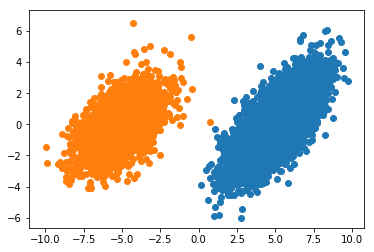

In [5]:
class Nomal(pd.DataFrame):
    """
    正規分布です。
    """
    @staticmethod
    def create(vec_m, mat_cov, p, num):
        """
        平均ベクトルと共分散行列を指定して正規分布を生成します。

        :param vec_m 平均ベクトル
        :param mat_cov 共分散行列
        :param p 事前確率(生起確率)
        :param num データの個数
        """
        return Nomal(data=np.random.multivariate_normal(vec_m, mat_cov, round(p*num)))
    
    @property
    def mean(self):
        return self.values.mean(axis=0)
    
    @property
    def cov(self):
        return CovarianceMatrix.genarate(self)

""" test """
num = 10000
cov = CovarianceMatrix([[1, 2], [2, 2]])
vec_mean = [5, 0]
p = 0.8
normal_c1 = Nomal.create(vec_m=vec_mean, mat_cov=cov, p=p, num=num)
plt.scatter(normal_c1.loc[:,0], normal_c1.loc[:,1])

cov = CovarianceMatrix([[1, 2], [2, 1]])
vec_mean = [-5, 0]
p = 0.2
normal_c2 = Nomal.create(vec_m=vec_mean, mat_cov=cov, p=p, num=num)
plt.scatter(normal_c2.loc[:,0], normal_c2.loc[:,1])
plt.show() 


In [6]:
class Classificater():
    """
    分類機です
    """
    def __init__(self, df_train, df_label):
        self.dataset = Dataset(df_train, df_label)
        init_omega = np.ones(df_train.shape[1] + 1)
        self.df_omega = pd.Series(data=init_omega)
    
    @classmethod
    def init(cls, df_train, df_label):
        """
        分類機のインスタンスを生成します。
        """
        if df_train.shape[0] != df_label.shape[0]:
            print(f"df_train : {df_train.shape}")
            print(f"df_label : {df_label.shape}")
            raise Exception('データセットの次元が不正です。')
        return cls(df_train=df_train, df_label=df_label)
    
    def print_shape(self):
        """
        形状を表示します
        """
        print(f"df_train : {self.dataset.df_train.shape}")
        print(f"df_label : {self.dataset.sr_label.shape}")
        print(f"df_omega : {self.df_omega.shape}")
    
    @abstractmethod
    def fit(self, num):
        """
        学習を行います。
        """
        pass
    
    @abstractmethod
    def predict(self, nd_sample):
        """
        予測を行います。
        """
        pass


df_train : (100, 2)
df_label : (100,)
df_omega : (3,)


<Figure size 432x288 with 0 Axes>

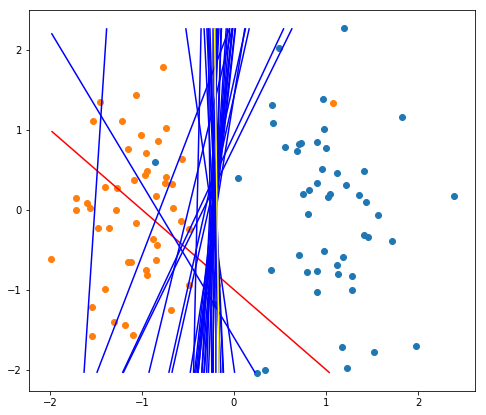

In [7]:
class PerceptronClassificater(Classificater):
    """
    パーセプトロンを用いた２次元の分類機です。
    """
    def __init__(self, df_train, df_label_, num, l_rate):
        df_label_ += df_label_ - 1
        super().__init__(df_train, df_label_)
        self.num = num
        self.l_rate = l_rate
    
    @property
    def is_converged(self):
        """
        収束しているか、否か
        """
        return False

    def fit(self):
        self._plot(color='red')
        for i in range(self.num):
            if self.is_converged:
                break
            self._fit_item()
        self._plot(color='yellow')

        
    def predict(self, nd_sample):
        nd_sample = np.insert(nd_sample,  2, 1, axis=0) # バイアスの追加
        y = self.df_omega.values.T.dot(nd_sample)
        return y
    
    def _fit_item(self):
        """
        一つの学習データで学習を行います。
        """
        for train, label in self.dataset.get_rows():
            nd_train = np.array(train)
            predict = self.predict(nd_train)
            if not self.__class__.is_determine(int(predict), label):
                self._update(nd_train, label)
                self._plot()
        

    def _update(self, nd_train, label):
        """
        パラメータを更新します。
        """
        self.df_omega[0] += self.l_rate * nd_train[0] * label
        self.df_omega[1] += self.l_rate * nd_train[1] * label
#         self.df_omega[2] += self.l_rate * 1 * label

    def _plot(self,color='blue'):
        """
        現在の判別境界をプロットします。
        """
        max_ = self.dataset.range[0]
        min_ = self.dataset.range[1]
        xlim, ylim = (min_[0], max_[0]), (min_[1], max_[1])
#         xlim, ylim = (-50, 50), (-50, 50)
        num = 50
        ranges, nd_grid = self.__class__._get_grid(xlim, ylim, num)
        result = self.predict(nd_grid)
        surface = result.reshape(len(ranges[0]), len(ranges[1]))
        cont = plt.contour(ranges[0], ranges[1], surface, levels=[0], colors=color)

    @staticmethod
    def is_determine(predict, answer):
        """
        予測があっているか否かを返します。
        """
        if answer == 1:
            return predict > 1
        elif answer == -1:
            return predict < -1
        else:
            print(f"answer value : {answer}")
            raise Exception("教師信号が不正です。")
            
    @staticmethod
    def _get_grid(xlim, ylim, num):
        """
        グリッドを生成します。
        """
        range_x = np.linspace(xlim[0], xlim[1], num)
        range_y = np.linspace(ylim[0], ylim[1], num)
        ranges = (range_x, range_y)
        nd_x = np.meshgrid(range_x, range_y)
        return ranges, np.array(nd_x).reshape(2, nd_x[0].size)


''' test '''
df_origin = get_data()
df_train = df_origin.drop('target',axis=1)
df_label = df_origin['target']
clf = PerceptronClassificater(df_train=df_train, df_label_=df_label, num=2, l_rate=0.5)

df_train_true = df_train[df_label == 1]
df_train_false = df_train[df_label == -1]

fig = plt.figure()
plt.figure(figsize=(8, 7))
plt.scatter(df_train_true.loc[:, 0], df_train_true.loc[:, 1])
plt.scatter(df_train_false.loc[:, 0], df_train_false.loc[:, 1])

clf.print_shape()
clf.fit()

df_train : (1000, 2)
df_label : (1000,)
df_omega : (3,)


<Figure size 432x288 with 0 Axes>

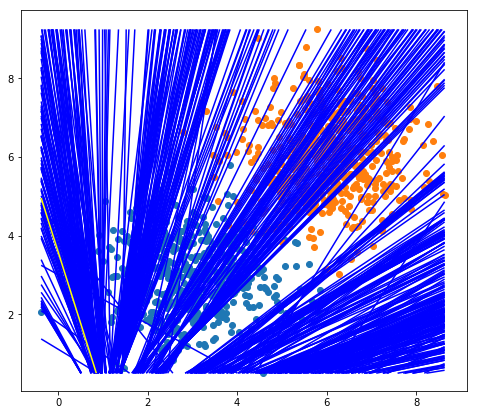

In [9]:
""" main """
import warnings
warnings.filterwarnings('ignore')

num = 1000

mean1 = np.array([3, 3])
mean2 = np.array([6, 6])

cov1 = CovarianceMatrix.compose([1, 1], [0])
cov2 = CovarianceMatrix.compose([2, 2], [0]) 

p1 = [0.5, 0.5]

nomal1 = Nomal.create(vec_m=mean1, mat_cov=cov1, p=p1[0], num=num)
nomal2 = Nomal.create(vec_m=mean2, mat_cov=cov1, p=p1[1], num=num)

nomal1['target'] = 1
nomal1.head()
nomal2['target'] = 0
nomal2.head()

df_sample = pd.concat([nomal1, nomal2])

df_train = df_sample.drop('target', axis=1)
df_label = df_sample['target']

df_train_true = df_train[df_label == 1]
df_train_false = df_train[df_label == 0]

fig = plt.figure()
plt.figure(figsize=(8, 7))
plt.scatter(df_train_true.loc[:, 0], df_train_true.loc[:, 1])
plt.scatter(df_train_false.loc[:, 0], df_train_false.loc[:, 1])

clf = PerceptronClassificater(df_train=df_train, df_label_=df_label.copy(), num=100, l_rate=0.1)
clf.print_shape()
clf.fit()

In [ ]:
class Line():
    """
    ２次元平面状に描画される線です。
    """
    def __init__(self, surface, levels, color):
        self.surface = surface
        self.levels = levels
        self.color = color
    
    @classmethod
    def init(clf, surface, levels, color):
        """
        Line のインスタンスを返します。
        """
        if surface.shape[0] != 2 or surface.shape[1] != 2:
            raise Exception('２次元データを入力してください')
        return clf(surface, levels, color)
    
    @classmethod
    def create_with_mesh(clf, xlim, ylim, num, levels, color):
        """
        """
        xrange = np.linspace(start=xlim[0], stop=xlim[1], num=num)
        yrange = np.linspace(start=ylim[0], stop=ylim[1], num=num)
        np.meshgrid(xrange, yrange)
        #　ここどうしよう・・・・
    
    @property
    def xrange(self):
        """
        x軸の幅を表すプロパティです
        """
        return self.surface[0].min(), self[0].max()
    
    @property
    def yrange(self):
        """
        y軸の幅を表すプロパティです
        """
        return self.surface[1].min(), self.surface[1].max()
    
    def plot(self):
        """
        線をプロットします
        """
        plt.contour(self.xrange, yrange, self.surface, levels=self.levels, colors=self.color)
    

class Ploter():
    """
    グラフの描画機です。
    """
    def __init__(self, lines, title, size):
        self.lines = lines
        self.title = title
        self.size = size
        pass
    
    def plot(self, xlim=None, ylim=None):
        """
        グラフをプロットします。
        """
        if xlim is None or ylim is None:
            xranges = np.array([line.xrange for line in self.lines])
            yranges = np.array([line.yrange for line in self.lines])
            xlim = (xranges.min(), xranges.max())
            ylim = (yranges.min(), yranges.max())
        
        fig = plt.figure()
        plt.figure(figsize = self.size)
        plt.xlim(xlim)
        plt.ylim(ylim)
        
        for line in lines:
            line.plot()
        
        plt.show()


""" test """
line = Line()
